## Requirements

In [ ]:
!pip install onnx
!pip install Pympler
!pip install onnx-tf==1.6.0
!pip install tensorflow==2.2.0
!pip install tensorflow-addons==0.11.2

## Reference
https://towardsdatascience.com/my-journey-in-converting-pytorch-to-tensorflow-lite-d244376beed


In [ ]:
import torch
import torchvision
import torch.nn as nn


dummy_input = torch.randn(10, 3, 224, 224, device='cuda')
model = torchvision.models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(4096, 10)
model = model.cuda()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [ ]:
# train with cifar10
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((224, 224)),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=2)




Files already downloaded and verified


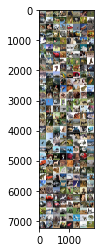

 ship  deer  frog   car


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())


In [ ]:
for epoch in range(10):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()


print('Finished Training')

Finished Training


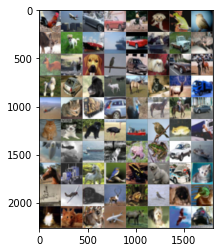

In [ ]:
imshow(torchvision.utils.make_grid(inputs.cpu()))


In [ ]:
inference_torch = model(inputs).detach().cpu().numpy()

In [ ]:
model(inputs)
labels

tensor([2, 0, 1, 1, 7, 5, 6, 2, 4, 5, 8, 8, 1, 8, 9, 3, 4, 7, 5, 2, 1, 5, 1, 7,
        5, 1, 5, 4, 7, 3, 4, 9, 0, 3, 9, 1, 2, 7, 7, 1, 3, 5, 5, 2, 8, 2, 6, 9,
        0, 0, 8, 3, 6, 6, 1, 8, 7, 9, 7, 2, 6, 5, 1, 3, 8, 0, 5, 4, 6, 2, 5, 2,
        3, 3, 3, 0, 4, 5, 2, 1], device='cuda:0')

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/model.pt') # 233MB 

In [ ]:
# Providing input and output names sets the display names for values
# within the model's graph. Setting these does not change the semantics
# of the graph; it is only for readability.
#
# The inputs to the network consist of the flat list of inputs (i.e.
# the values you would pass to the forward() method) followed by the
# flat list of parameters. You can partially specify names, i.e. provide
# a list here shorter than the number of inputs to the model, and we will
# only set that subset of names, starting from the beginning.
input_names = [ "actual_input_1" ] + [ "learned_%d" % i for i in range(16) ]
output_names = [ "output1" ]

torch.onnx.export(model.cpu(), dummy_input.cpu(), "alexnet.onnx", verbose=True, input_names=input_names, output_names=output_names)

graph(%actual_input_1 : Float(10:150528, 3:50176, 224:224, 224:1, requires_grad=0, device=cpu),
      %learned_0 : Float(64:363, 3:121, 11:11, 11:1, requires_grad=1, device=cpu),
      %learned_1 : Float(64:1, requires_grad=1, device=cpu),
      %learned_2 : Float(192:1600, 64:25, 5:5, 5:1, requires_grad=1, device=cpu),
      %learned_3 : Float(192:1, requires_grad=1, device=cpu),
      %learned_4 : Float(384:1728, 192:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %learned_5 : Float(384:1, requires_grad=1, device=cpu),
      %learned_6 : Float(256:3456, 384:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %learned_7 : Float(256:1, requires_grad=1, device=cpu),
      %learned_8 : Float(256:2304, 256:9, 3:3, 3:1, requires_grad=1, device=cpu),
      %learned_9 : Float(256:1, requires_grad=1, device=cpu),
      %learned_10 : Float(4096:9216, 9216:1, requires_grad=1, device=cpu),
      %learned_11 : Float(4096:1, requires_grad=1, device=cpu),
      %learned_12 : Float(4096:4096, 4096:1, 

In [ ]:
import onnx
model = onnx.load("alexnet.onnx")
# Check that the IR is well formed
onnx.checker.check_model(model)

# Print a human readable representation of the graph
onnx.helper.printable_graph(model.graph)

'graph torch-jit-export (\n  %actual_input_1[FLOAT, 10x3x224x224]\n) initializers (\n  %learned_0[FLOAT, 64x3x11x11]\n  %learned_1[FLOAT, 64]\n  %learned_10[FLOAT, 4096x9216]\n  %learned_11[FLOAT, 4096]\n  %learned_12[FLOAT, 4096x4096]\n  %learned_13[FLOAT, 4096]\n  %learned_14[FLOAT, 10x4096]\n  %learned_15[FLOAT, 10]\n  %learned_2[FLOAT, 192x64x5x5]\n  %learned_3[FLOAT, 192]\n  %learned_4[FLOAT, 384x192x3x3]\n  %learned_5[FLOAT, 384]\n  %learned_6[FLOAT, 256x384x3x3]\n  %learned_7[FLOAT, 256]\n  %learned_8[FLOAT, 256x256x3x3]\n  %learned_9[FLOAT, 256]\n) {\n  %17 = Conv[dilations = [1, 1], group = 1, kernel_shape = [11, 11], pads = [2, 2, 2, 2], strides = [4, 4]](%actual_input_1, %learned_0, %learned_1)\n  %18 = Relu(%17)\n  %19 = MaxPool[kernel_shape = [3, 3], pads = [0, 0, 0, 0], strides = [2, 2]](%18)\n  %20 = Conv[dilations = [1, 1], group = 1, kernel_shape = [5, 5], pads = [2, 2, 2, 2], strides = [1, 1]](%19, %learned_2, %learned_3)\n  %21 = Relu(%20)\n  %22 = MaxPool[kernel_sha

In [ ]:
# onnx to tensorflow graph
from onnx_tf.backend import prepare
import onnx

In [ ]:
tf_rep = prepare(model)

2020-12-23 14:57:07,071 - onnx-tf - INFO - Fail to get since_version of BitShift in domain `` with max_inclusive_version=9. Set to 1.
2020-12-23 14:57:07,073 - onnx-tf - INFO - Fail to get since_version of ConcatFromSequence in domain `` with max_inclusive_version=9. Set to 1.
2020-12-23 14:57:07,074 - onnx-tf - INFO - Unknown op ConstantFill in domain `ai.onnx`.
2020-12-23 14:57:07,076 - onnx-tf - INFO - Fail to get since_version of ConvInteger in domain `` with max_inclusive_version=9. Set to 1.
2020-12-23 14:57:07,077 - onnx-tf - INFO - Fail to get since_version of CumSum in domain `` with max_inclusive_version=9. Set to 1.
2020-12-23 14:57:07,079 - onnx-tf - INFO - Fail to get since_version of DequantizeLinear in domain `` with max_inclusive_version=9. Set to 1.
2020-12-23 14:57:07,080 - onnx-tf - INFO - Fail to get since_version of Det in domain `` with max_inclusive_version=9. Set to 1.
2020-12-23 14:57:07,083 - onnx-tf - INFO - Fail to get since_version of DynamicQuantizeLinear 

In [ ]:
tf_rep.export_graph('/content/gdrive/MyDrive/model.pb') # 233MB

## TFlite

In [ ]:
import tensorflow as tf

In [ ]:
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    '/content/gdrive/MyDrive/model.pb',
    input_arrays=input_names,
    output_arrays=output_names,
)

In [ ]:
converter.experimental_new_converter = True

In [ ]:
converter.target_spec.supported_ops = [
                                       tf.compat.v1.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.compat.v1.lite.OpsSet.SELECT_TF_OPS,
]

In [ ]:
tf_lite_model = converter.convert()

In [ ]:
with open('/content/gdrive/MyDrive/model.tflite', 'wb') as f:
    f.write(tf_lite_model) # 14KB

## Inference: torch vs tflite

In [ ]:

!pip install tensorflow==2.3.0
!pip install tensorflow-addons==0.11.0
!pip install onnxruntime==1.4.0

     |████████████████████████████████| 320.4MB 51kB/s 
     |████████████████████████████████| 460kB 41.7MB/s 
     |████████████████████████████████| 2.9MB 40.6MB/s 
     |████████████████████████████████| 10.6MB 38.6MB/s 
     |████████████████████████████████| 20.1MB 1.3MB/s 
ERROR: tf-nightly 2.5.0.dev20201223 has requirement h5py~=3.1.0, but you'll have h5py 2.10.0 which is incompatible.
ERROR: tf-nightly 2.5.0.dev20201223 has requirement numpy~=1.19.2, but you'll have numpy 1.18.5 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: numpy 1.19.4
    Uninstalling numpy-1.19.4:
      Successfully u

     |████████████████████████████████| 1.1MB 9.4MB/s 
  Found existing installation: tensorflow-addons 0.11.2
    Uninstalling tensorflow-addons-0.11.2:
      Successfully uninstalled tensorflow-addons-0.11.2


     |████████████████████████████████| 4.4MB 8.4MB/s 


In [ ]:
!pip uninstall tensorflow==2.3.0

y


In [ ]:

import tensorflow as tf
print(f"Using tensorflow {tf.__version__}")

Using tensorflow 2.2.0


## tflite infer: check library version

In [ ]:
import os
import tensorflow as tf
import numpy as np

TFLITE_PATH = '/content/gdrive/MyDrive/model.tflite'

example_input = inputs.cpu().numpy()
print(f"Using tensorflow {tf.__version__}") # make sure it's the nightly build
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
interpreter = tf.compat.v1.lite.Interpreter(model_path=TFLITE_PATH)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], example_input)
interpreter.invoke()
print(interpreter.get_tensor(output_details[0]['index'])) # printing the result

Using tensorflow 2.2.0


RuntimeError: ignored

In [ ]:
interpreter.allocate_tensors()
interpreter.get_tensor(1)

RuntimeError: ignored